# 주제 : LSTM을 활용해 주가 예측 모델 구현하기

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## Step 1. 데이터 불러오기 및 EDA

### 문제 01. 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

### 문제 02. FinanceDataReader import

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [2]:
# !pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

### 문제 03. 삼성전자 데이터 불러오기

In [4]:
# fdr 라이브러리를 활용해 삼성전자 주가 데이터를 불러오세요.
# 대상 : 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

In [5]:
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-06-30,1259,1290,1254,1260,100240,NaN
1997-07-01,1259,1286,1259,1269,167900,0.007143
1997-07-02,1277,1313,1277,1296,169940,0.021277
1997-07-03,1295,1304,1283,1290,108460,-0.004630
1997-07-04,1295,1304,1286,1296,101780,0.004651


매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

### 문제 04. 삼성전자 데이터 EDA

In [6]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-06-30,81100,81400,80700,80700,13288643,-0.003704
2021-07-01,80500,80600,80000,80100,13382882,-0.007435
2021-07-02,80000,80400,79900,80000,8753097,-0.001248
2021-07-05,80100,80800,80000,80400,8330969,0.005000
2021-07-06,80600,81200,80500,81200,12078386,0.009950


In [7]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 1997-06-30 to 2021-07-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6000 non-null   int64  
 1   High    6000 non-null   int64  
 2   Low     6000 non-null   int64  
 3   Close   6000 non-null   int64  
 4   Volume  6000 non-null   int64  
 5   Change  5999 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 328.1 KB


In [8]:
samsung.describe()

,Open,High,Low,Close,Volume,Change
count,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,5999.000000
mean,20756.542667,20981.123333,20531.385667,20782.474667,2.548288e+06,0.001024
std,18242.897132,18414.185864,18075.988516,18248.000379,6.285571e+06,0.025756
min,0.000000,0.000000,0.000000,627.000000,0.000000e+00,-0.137566
25%,7400.000000,7514.250000,7297.500000,7400.000000,2.753012e+05,-0.012231
50%,13750.000000,13929.500000,13580.000000,13790.000000,4.493920e+05,0.000000
75%,28010.000000,28225.000000,27715.000000,28020.000000,8.164582e+05,0.012959
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.150000


**미국 주식 데이터**도 가져올 수 있습니다.

### 문제 05. 애플 데이터 불러오기

In [9]:
# fdr 라이브러리를 활용해 Apple(AAPL) 데이터를 불러오세요.
apple = fdr.DataReader("AAPL")

### 문제 06. 애플 데이터 EDA

In [10]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-12-12,0.13,0.13,0.13,0.13,469030000.0,-0.9988
1980-12-15,0.12,0.12,0.12,0.12,175880000.0,-0.0769
1980-12-16,0.11,0.11,0.11,0.11,105730000.0,-0.0833
1980-12-17,0.12,0.12,0.12,0.12,86440000.0,0.0909
1980-12-18,0.12,0.12,0.12,0.12,73450000.0,0.0000


In [11]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10227 entries, 1980-12-12 to 2021-07-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10227 non-null  float64
 1   Open    10227 non-null  float64
 2   High    10227 non-null  float64
 3   Low     10227 non-null  float64
 4   Volume  10227 non-null  float64
 5   Change  10227 non-null  float64
dtypes: float64(6)
memory usage: 559.3 KB


In [12]:
apple.describe()

,Close,Open,High,Low,Volume,Change
count,10227.000000,10227.000000,10227.000000,10227.000000,1.022700e+04,10227.000000
mean,11.412756,11.409691,11.531712,11.284658,3.365854e+08,0.001047
std,23.499021,23.493213,23.756235,23.219592,3.412661e+08,0.034703
min,0.050000,0.050000,0.050000,0.050000,1.390000e+06,-0.998800
25%,0.280000,0.280000,0.280000,0.270000,1.282050e+08,-0.008200
50%,0.450000,0.450000,0.460000,0.440000,2.240900e+08,0.000000
75%,12.380000,12.375000,12.490000,12.315000,4.187800e+08,0.012300
max,143.160000,143.600000,145.090000,141.370000,7.430000e+09,0.277800


### 문제 07. 특정 시점(2017년) 이후 데이터 불러오기

In [13]:
# Apple(AAPL), 2017년
apple = fdr.DataReader('AAPL', '2017')

In [14]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


### 문제 08. 날짜를 지정하여 특정 범위(40년간) 데이터 불러오기

In [15]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [16]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [17]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


### 문제 09. '금'과 '달러' 데이터도 가져올 수 있습니다. 두 데이터를 불러와 head를 출력해보세요.

*[GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader) 참고

In [18]:
# 금 선물 가격
gold = fdr.DataReader('ZG')

In [19]:
gold.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-01-02,575.5,562.5,577.0,558.0,7260.0,0.0785
1980-01-03,625.0,627.0,640.0,603.0,20750.0,0.0860
1980-01-04,603.6,609.5,621.0,573.0,2660.0,-0.0342
1980-01-07,627.0,629.0,635.0,611.0,3000.0,0.0388
1980-01-08,602.5,611.5,619.0,600.0,750.0,-0.0391


In [20]:
gold.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-06-28,1780.7,1782.0,1786.1,1770.4,160790.0,0.0016
2021-06-29,1763.6,1778.8,1779.2,1750.1,239910.0,-0.0096
2021-06-30,1771.6,1761.9,1774.7,1753.2,177890.0,0.0045
2021-07-01,1776.8,1770.8,1783.4,1765.9,171440.0,0.0029
2021-07-02,1783.3,1777.5,1795.9,1774.4,205860.0,0.0037


In [21]:
# 달러 가격
dollar = fdr.DataReader('USD/KRW')

In [22]:
dollar.head()

,Close,Open,High,Low,Change
Date,,,,,
1981-04-14,676.70,676.70,676.70,676.70,0.0019
1981-04-15,676.70,676.70,676.70,676.70,0.0000
1981-04-16,676.70,676.70,676.70,676.70,0.0000
1981-04-17,676.75,676.75,676.75,676.75,0.0001
1981-04-20,676.70,676.70,676.70,676.70,-0.0001


In [23]:
dollar.tail()

,Close,Open,High,Low,Change
Date,,,,,
2021-06-30,1130.48,1131.80,1132.89,1125.59,-0.0010
2021-07-01,1134.33,1130.63,1135.98,1128.28,0.0034
2021-07-02,1130.53,1134.51,1138.60,1129.60,-0.0033
2021-07-05,1130.42,1130.77,1132.72,1128.13,-0.0001
2021-07-06,1134.05,1130.36,1135.46,1129.44,0.0032


### 문제 10. 삼성전자 데이터를 STOCK_CODE에 저장하고 인덱스를 확인해보세요

In [24]:
# 문제 03과 코드는 동일합니다.
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [25]:
# fdr 라이브러리를 활용해 삼성전자 데이터를 불러오세요 
stock = fdr.DataReader(STOCK_CODE)
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-06-30,1259,1290,1254,1260,100240,NaN
1997-07-01,1259,1286,1259,1269,167900,0.007143
1997-07-02,1277,1313,1277,1296,169940,0.021277
1997-07-03,1295,1304,1283,1290,108460,-0.004630
1997-07-04,1295,1304,1286,1296,101780,0.004651


In [26]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-06-30,81100,81400,80700,80700,13288643,-0.003704
2021-07-01,80500,80600,80000,80100,13382882,-0.007435
2021-07-02,80000,80400,79900,80000,8753097,-0.001248
2021-07-05,80100,80800,80000,80400,8330969,0.005000
2021-07-06,80600,81200,80500,81200,12078386,0.009950


In [27]:
# 인덱스를 확인해보세요.
stock.index

DatetimeIndex(['1997-06-30', '1997-07-01', '1997-07-02', '1997-07-03',
               '1997-07-04', '1997-07-05', '1997-07-07', '1997-07-08',
               '1997-07-09', '1997-07-10',
               ...
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

## Step 2. 시계열 데이터 시각화


### 문제 11. 인덱스가 `DatetimeIndex`로 정의되어 있다면, 연도, 월, 일을 쪼갤 수 있습니다. 데이터를 분리해주세요.

In [28]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [29]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1997-06-30,1259,1290,1254,1260,100240,NaN,1997,6,30
1997-07-01,1259,1286,1259,1269,167900,0.007143,1997,7,1
1997-07-02,1277,1313,1277,1296,169940,0.021277,1997,7,2
1997-07-03,1295,1304,1283,1290,108460,-0.004630,1997,7,3
1997-07-04,1295,1304,1286,1296,101780,0.004651,1997,7,4


### 문제 12. 연도별, 월별 피봇테이블을 각각 구현해보세요.

In [30]:
stock.groupby("Year").mean()

,Open,High,Low,Close,Volume,Change,Month,Day
Year,,,,,,,,
1997,1054.081081,1072.689189,1033.668919,1052.905405,2.251198e+05,-0.003422,9.418919,15.506757
1998,1113.948630,1144.623288,1083.828767,1113.702055,6.127810e+05,0.003875,6.462329,15.801370
1999,3042.759036,3131.196787,2968.831325,3046.895582,8.627532e+05,0.005742,6.578313,15.582329
2000,5382.593361,5516.601660,5248.804979,5372.406639,1.118580e+06,-0.001001,6.464730,16.120332
2001,3993.719512,4071.313008,3927.918699,4003.617886,7.313713e+05,0.002954,6.524390,16.004065
2002,6859.209016,6971.897541,6752.295082,6865.122951,8.511943e+05,0.000935,6.524590,16.004098
2003,7446.457490,7545.068826,7352.323887,7454.453441,6.190000e+05,0.001734,6.493927,15.931174
2004,9647.698795,9765.811245,9523.477912,9647.389558,5.721826e+05,0.000240,6.618474,15.602410
2005,10729.016064,10835.558233,10634.220884,10739.236948,4.305591e+05,0.001628,6.578313,15.975904


In [31]:
stock.groupby(["Year","Month"]).mean()

Open          High           Low         Close  \
Year Month                                                           
1997 6       1259.000000   1290.000000   1254.000000   1260.000000   
     7       1228.769231   1241.461538   1216.423077   1227.500000   
     8       1261.840000   1278.040000   1250.640000   1267.280000   
     9       1224.652174   1238.739130   1209.217391   1224.521739   
     10      1027.230769   1045.730769    995.307692   1014.000000   
...                  ...           ...           ...           ...   
2021 3      82250.000000  82763.636364  81609.090909  82072.727273   
     4      83786.363636  84150.000000  83095.454545  83586.363636   
     5      80547.368421  81105.263158  80015.789474  80521.052632   
     6      81195.454545  81590.909091  80740.909091  81104.545455   
     7      80300.000000  80750.000000  80100.000000  80425.000000   

                  Volume    Change        Day  
Year Month                                     
1997 6      1.002400e+05       NaN  30.000000  
     7      7.374308e+04 -0.003107  15.884615  
     8      1.537483e+05  0.003438  15.840000  
     9      6.507870e+04 -0.002450  15.086957  
     10     1.376285e+05 -0.020538  16.576923  
...                  ...       ...        ...  
2021 3      1.761874e+07 -0.000570  16.318182  
     4      1.695174e+07  0.000101  16.045455  
     5      1.853742e+07 -0.000592  16.684211  
     6      1.514088e+07  0.000147  15.318182  
     7      1.063633e+07  0.001567   3.500000  

[290 rows x 7 columns]

### 문제 13. matplotlib을 활용해 시간에 따른 주식 가격 시계열 그래프를 그려보세요.

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


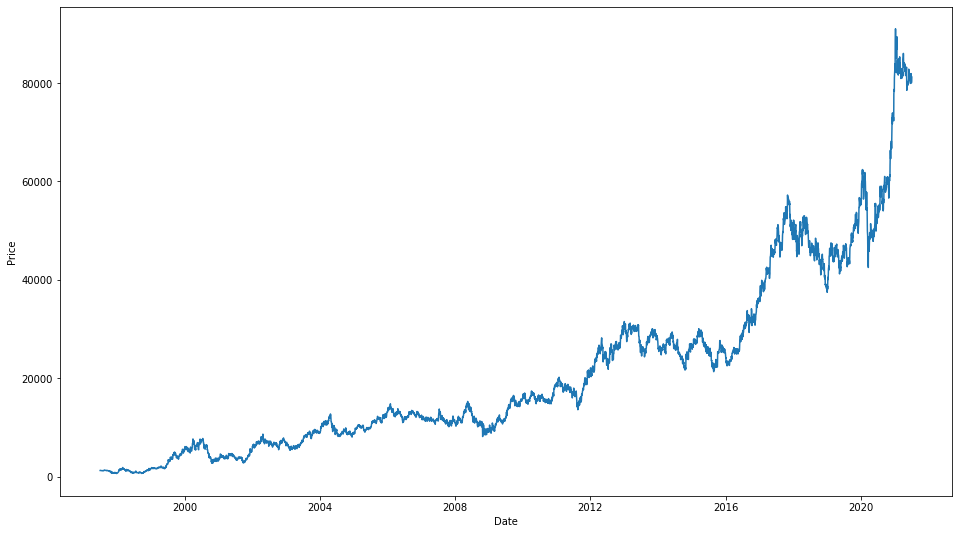

In [32]:
plt.figure(figsize=(16, 9))
# 코드를 이어서 작성해주세요.
plt.plot(stock["Close"])
plt.xlabel("Date")
plt.ylabel('Price')
plt.show()

### 문제 14. subplots를 활용해 그래프 4개(2,2)를 동시에 그려보세요.

In [33]:
time_steps = [['1990','2000'],
             ['2000','2010'],
             ['2010','2015'],
             ['2015','2020']]

In [34]:
stock.loc[(stock.index > time_steps[0][0]) &  (stock.index< time_steps[0][1])]

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1997-06-30,1259,1290,1254,1260,100240,NaN,1997,6,30
1997-07-01,1259,1286,1259,1269,167900,0.007143,1997,7,1
1997-07-02,1277,1313,1277,1296,169940,0.021277,1997,7,2
1997-07-03,1295,1304,1283,1290,108460,-0.004630,1997,7,3
1997-07-04,1295,1304,1286,1296,101780,0.004651,1997,7,4
...,...,...,...,...,...,...,...,...,...
1999-12-22,5140,5350,5060,5280,826858,0.047619,1999,12,22
1999-12-23,5280,5700,5240,5580,1057262,0.056818,1999,12,23
1999-12-24,5700,5720,5360,5460,708446,-0.021505,1999,12,24


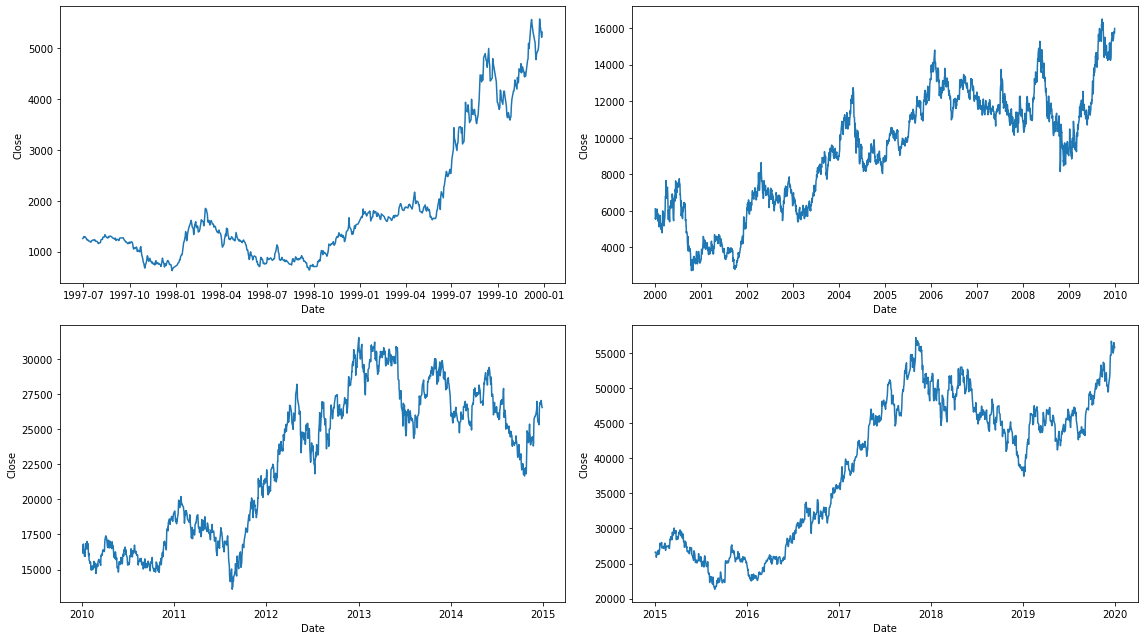

In [35]:
# 1990~2000, 2000~2010, 2010~2015, 2015~2020


fig, axis = plt.subplots(2,2)
fig.set_size_inches(16,9)

for i in range(4):
    ax = axis[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) &  (stock.index< time_steps[i][1])]
    sns.lineplot(y=df["Close"], x=df.index, data=df, ax=ax)
plt.tight_layout()
plt.show()

## Step 3. 시계열 데이터의 전처리

### 문제 15. MinMaxScaler를 활요해 데이터 전처리를 수행합니다.

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [36]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1997-06-30,1259,1290,1254,1260,100240,NaN,1997,6,30
1997-07-01,1259,1286,1259,1269,167900,0.007143,1997,7,1
1997-07-02,1277,1313,1277,1296,169940,0.021277,1997,7,2
1997-07-03,1295,1304,1283,1290,108460,-0.004630,1997,7,3
1997-07-04,1295,1304,1286,1296,101780,0.004651,1997,7,4


In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])

In [38]:
scaled.min(), scaled.max()

(0.0, 1.0)

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [39]:
# 아래 코드는 그대로 실행해주세요.
df = pd.DataFrame(scaled, columns=scale_cols)

In [40]:
df.head()

,Open,High,Low,Close,Volume
0,0.013942,0.013326,0.014011,0.007004,0.001110
1,0.013942,0.013285,0.014067,0.007104,0.001859
2,0.014142,0.013564,0.014268,0.007403,0.001882
3,0.014341,0.013471,0.014335,0.007336,0.001201
4,0.014341,0.013471,0.014369,0.007403,0.001127


### 문제 16. 모델 학습을 위해 train 데이터와 test 데이터로 분할해주세요.

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
# Close 컬럼이 예측할 데이터입니다.
# test_size는 0.2, random_state는 0으로 지정해주세요.
# shuffle을 수행하지 않습니다.
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size=0.2, random_state=0,shuffle=False)

### 문제 17. train 데이터와 test 데이터의 shape을 각각 살펴봅니다.

In [43]:
x_train.shape, x_test.shape

((4800, 4), (1200, 4))

In [44]:
y_train.shape, y_test.shape

((4800,), (1200,))

In [45]:
x_train

,Open,High,Low,Volume
0,0.013942,0.013326,0.014011,0.001110
1,0.013942,0.013285,0.014067,0.001859
2,0.014142,0.013564,0.014268,0.001882
3,0.014341,0.013471,0.014335,0.001201
4,0.014341,0.013471,0.014369,0.001127
...,...,...,...,...
4795,0.347065,0.324380,0.342793,0.002733
4796,0.341307,0.322107,0.341006,0.002333
4797,0.345293,0.324380,0.345028,0.002320
4798,0.342193,0.325620,0.345251,0.002401


### 문제 18. TensorFlow Dataset을 활용해 시퀀스 데이터셋을 함수로 구현해주세요

In [46]:
import tensorflow as tf

In [47]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size + 1))
    
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda x: (x[:-1], x[-1]))
    return ds.batch(batch_size).prefetch(1)

## Step 4. 모델 구현하기

### 문제 19. Hyperparameter를 정의하고 데이터에 적용해주세요.

In [48]:
# 아래 코드는 그대로 실행해주세요.
WINDOW_SIZE=20
BATCH_SIZE=32

In [49]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
# WINDOW_SIZE와 BATCH_SIZE를 각 데이터셋에 적용해주세요.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [50]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다. 그대로 실행해보고, 데이터의 shape을 살펴보세요.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


### 문제 20. Sequential 모델을 구현합니다. 

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def seq_model():
    inputs  = Input((20,1))
    x = Conv1D(filters=32, kernel_size=5, padding='causal', activation='relu')(inputs)
    x = LSTM(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

model = Sequential([
     # 1차원 feature map 생성합니다. filters는 32로, kernel_size는 5로 지정해주세요.
    Conv1D(filters=32, kernel_size=5, padding='causal', activation='relu', input_shape=[WINDOW_SIZE, 1]),
    # LSTM과 Dense 레이어를 사용해주세요. 필요한 경우 활성함수는 relu로 지정합니다.
    LSTM(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 32)            192       
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________


In [53]:
# model2 = seq_model()
# model2.summary()

### 문제 21. 모델을 Compile합니다. loss는 Huber 함수를 사용하고 optimizer는 Adam을 사용해주세요.

In [54]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
adam = Adam(0.0005)
model.compile(optimizer=adam, loss=loss, metrics=['mse'])
# model2.compile(optimizer='adam', loss=loss, metrics=['mae'])

In [55]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [56]:
# callbacks로 앞에서 구현한 earlystopping과 checkpoint를 지정해주세요.
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
150/150 [==============================] - 18s 79ms/step - loss: 1.3155e-04 - mse: 2.6309e-04 - val_loss: 0.0011 - val_mse: 0.0023

Epoch 00001: val_loss improved from inf to 0.00114, saving model to tmp\ckeckpointer.ckpt
Epoch 2/50
150/150 [==============================] - 12s 79ms/step - loss: 2.0728e-05 - mse: 4.1456e-05 - val_loss: 6.7948e-04 - val_mse: 0.0014

Epoch 00002: val_loss improved from 0.00114 to 0.00068, saving model to tmp\ckeckpointer.ckpt
Epoch 3/50
150/150 [==============================] - 11s 72ms/step - loss: 1.9661e-05 - mse: 3.9322e-05 - val_loss: 9.1802e-04 - val_mse: 0.0018

Epoch 00003: val_loss did not improve from 0.00068
Epoch 4/50
150/150 [==============================] - 11s 73ms/step - loss: 1.9717e-05 - mse: 3.9434e-05 - val_loss: 5.0538e-04 - val_mse: 0.0010

Epoch 00004: val_loss improved from 0.00068 to 0.00051, saving model to tmp\ckeckpointer.ckpt
Epoch 5/50
150/150 [==============================] - 11s 74ms/step - loss: 2.1149e-05 

In [57]:
# hist2 = model2.fit(train_data, 
#                     validation_data=(test_data),
#                    epochs=15,
#                    callbacks=[earlystopping, checkpoint]
# )

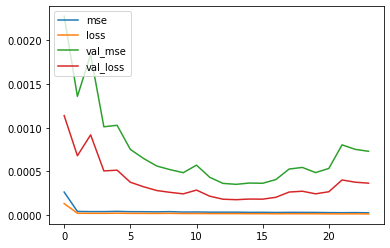

In [59]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_mse'], label='val_mse')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# plt.plot(hist2.history['mae'], label='mae')
# plt.plot(hist2.history['loss'], label='loss')
# plt.plot(hist2.history['val_mae'], label='val_mae')
# plt.plot(hist2.history['val_loss'], label='val_loss')
# plt.show()

## Step 5. 모델을 활용한 예측 및 결과 시각화

### 문제 24. 저장한 ModelCheckpoint 를 불러옵니다.

In [60]:
model.load_weights(filename)

### 문제 25. `test_data`를 활용하여 예측을 수행합니다.

In [61]:
pred = model.predict(test_data)

In [62]:
pred

array([[0.33919805],
       [0.33629403],
       [0.3352508 ],
       ...,
       [0.90280926],
       [0.90141433],
       [0.8985623 ]], dtype=float32)

### 문제 26. matplotlib을 활용해 예측 데이터를 시각화해주세요.

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

In [63]:
y_test

4800    0.356002
4801    0.363748
4802    0.361535
4803    0.366404
4804    0.358879
          ...   
5995    0.886028
5996    0.879389
5997    0.878282
5998    0.882708
5999    0.891561
Name: Close, Length: 1200, dtype: float64

In [64]:
np.array(y_test), np.asarray(y_test)

(array([0.35600235, 0.36374802, 0.36153497, ..., 0.87828223, 0.88270833,
        0.89156053]),
 array([0.35600235, 0.36374802, 0.36153497, ..., 0.87828223, 0.88270833,
        0.89156053]))

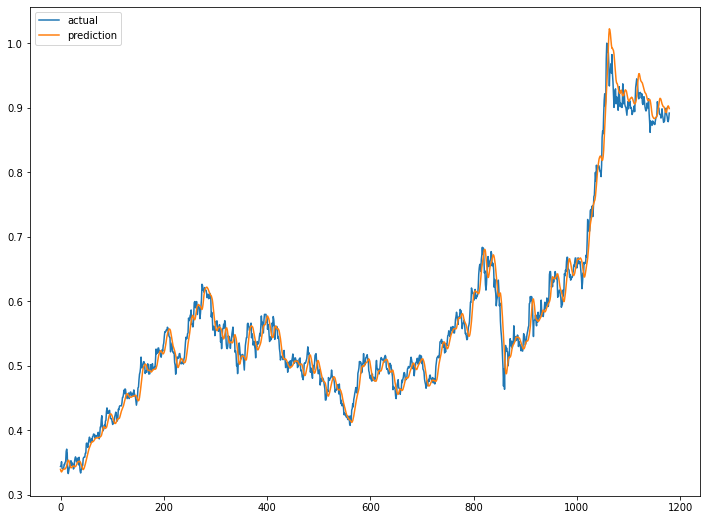

In [65]:
# 20일치의 데이터로 21일치를 예측하므로 test_data 사용시 이전 20일은 예측하지 않습니다.
# 따라서 y_test 데이터에 [20:]로 슬라이싱해주세요.
plt.figure(figsize=(12, 9))
plt.plot(np.array(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')

plt.legend()
plt.show()